# Satellite sea ice type

## Import libraries

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

## Set Parameters

In [2]:
start_year = 1991
stop_year = 2020

NERSC_PATH = "/data/wp5/mangini_fabio/nersc_ice_age_v2p1"

## Define requests

In [3]:
collection_id = "satellite-sea-ice-edge-type"

common_request = {
    "cdr_type": "cdr",
    "variable": "sea_ice_type",
    "region": "northern_hemisphere",
    "version": "3_0",
    "day": [f"{day:02d}" for day in range(1, 32)],
}

requests = [
    common_request
    | {
        "year": [str(year) for year in range(start_year, stop_year)],
        "month": [f"{month:02d}" for month in range(10, 13)],
    },
    common_request
    | {
        "year": [str(year + 1) for year in range(start_year, stop_year)],
        "month": [f"{month:02d}" for month in range(1, 5)],
    },
]

## Define functions to cache

In [4]:
def get_nersc_multiyear_ice(
    time,
    use_fyi,
    age_threshold,
    conc_threshold,
    nersc_ice_age_path,
):
    if nersc_ice_age_path is None:
        nersc_ice_age_path = NERSC_PATH
    paths = time.dt.strftime(
        f"{nersc_ice_age_path}/%Y/arctic25km_sea_ice_age_v2p1_%Y%m%d.nc"
    )
    ds_age = xr.open_mfdataset(set(paths.values)).rename(x="xc", y="yc")

    if age_threshold is not None:
        assert not use_fyi
        assert conc_threshold is None
        return ds_age["sia"] > age_threshold

    assert conc_threshold is not None

    conc_myi = ds_age["conc_2yi"]
    n = 3
    while (varname := f"conc_{n}yi") in ds_age.variables:
        conc_myi += ds_age[varname]
        n += 1

    if not use_fyi:
        return conc_myi > conc_threshold

    conc_fyi = ds_age["conc_1yi"]
    return ((conc_myi + conc_fyi) > conc_threshold) & (conc_myi > conc_fyi)


def compute_spatial_sum(da, grid_cell_area, dim=("xc", "yc")):
    return grid_cell_area * da.sum(dim=dim)


def compute_sea_ice_evaluation_diagnostics(
    ds,
    use_ambiguous,
    use_fyi,
    age_threshold,
    conc_threshold,
):
    # grid cell area of sea ice edge grid
    (dx,) = set(ds["xc"].diff("xc").values)
    grid_cell_area = (dx**2) * 1.0e-6  # 10^6 km2

    # Masks
    da_cds = ds.cf["sea_ice_classification"]
    da_cds = (da_cds >= 3) if use_ambiguous else (da_cds == 3)
    da_nersc = get_nersc_multiyear_ice(
        ds["time"],
        use_fyi=use_fyi,
        age_threshold=age_threshold,
        conc_threshold=conc_threshold,
        nersc_ice_age_path=None,
    )
    da_nersc = da_nersc.drop_vars(["xc", "yc"])

    # Fill variables
    units = "$10^6$km$^2$",
    dataarrays = {}
    dataarrays["mysi_extent"] = compute_spatial_sum(da_cds, grid_cell_area)
    dataarrays["mysi_extent"].attrs = {
        "standard_name": "multi_year_sea_ice_extent",
        "units": units,
        "long_name": "Multi-year sea ice extent",
    }

    dataarrays["mysi_extent_age"] = compute_spatial_sum(da_nersc, grid_cell_area)
    dataarrays["mysi_extent_age"].attrs = {
        "standard_name": "multi_year_sea_ice_extent_age",
        "units": "$10^6$km$^2$",
        "long_name": "Multi-year sea ice extent from NERSC sea ice age product",
    }

    over = compute_spatial_sum(da_cds & ~da_nersc, grid_cell_area)
    under = compute_spatial_sum(~da_cds & da_nersc, grid_cell_area)
    dataarrays["mysi_extent_bias"] = over - under
    dataarrays["mysi_extent_bias"].attrs = {
        "standard_name": "multi_year_sea_ice_extent_bias",
        "units": "$10^6$km$^2$",
        "long_name": "Multi-year sea ice extent bias",
    }

    dataarrays["iite"] = over + under
    dataarrays["iite"].attrs = {
        "standard_name": "integrated_ice_type_error",
        "units": "$10^6$km$^2$",
        "long_name": "Integrated ice type error",
    }
    return xr.Dataset(dataarrays)

## Download and transform data

In [5]:
datasets = []
for use_ambiguous in (True, False):
    print(f"{use_ambiguous=}")
    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=compute_sea_ice_evaluation_diagnostics,
        transform_func_kwargs={
            "use_ambiguous": use_ambiguous,
            "use_fyi": True,
            "age_threshold": None,
            "conc_threshold": 0.15,
        },
        chunks={"year": 1},
    )
    datasets.append(ds.expand_dims(use_ambiguous=[use_ambiguous]).compute())
ds_timeseries = xr.concat(datasets, "use_ambiguous")

use_ambiguous=True


100%|██████████| 58/58 [00:04<00:00, 14.38it/s]


use_ambiguous=False


100%|██████████| 58/58 [00:03<00:00, 19.17it/s]


## Plotting functions

In [17]:
def rearrange_year_vs_monthday(ds):
    ds = ds.convert_calendar("noleap")
    year = ds["time"].dt.year
    year = year.where(ds["time"].dt.month>=10, year-1)
    coords = {
        "year": ("time", year.values),
        "monthday": ("time", ds["time"].dt.strftime("%m-%d").values),
    }
    ds = ds.assign_coords(coords)
    return ds.set_index(time=tuple(coords)).unstack("time")


def plot_against_monthday(
    ds,
    cmap="viridis",
    **kwargs,
):
    defaults = {
        "row": "variable",
        "x": "time",
        "hue": "year",
        "add_legend": False,
    }
    kwargs = defaults | kwargs

    ds = rearrange_year_vs_monthday(ds)

    da = ds.to_array()
    time = pd.to_datetime(
        [
            f"200{'1' if int(monthday[:2]) >= 10 else '2'}-{monthday}"
            for monthday in da["monthday"].values
        ]
    )
    da = da.assign_coords(time=("monthday", time)).sortby("time")

    colors = plt.get_cmap(cmap, da.sizes["year"]).colors
    with plt.rc_context({"axes.prop_cycle": plt.cycler(color=colors)}):
        facet = da.plot(**kwargs)

    for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
        ax.grid()
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
        ax.xaxis.set_tick_params(rotation=45)

    for ax in facet.axs[:, 0]:
        ax.set_ylabel(ds[sel_dict["variable"]].attrs["units"])

    scalar_mappable = plt.cm.ScalarMappable(
        cmap=cmap,
        norm=plt.Normalize(vmin=da["year"].min(), vmax=da["year"].max()),
    )
    facet.fig.colorbar(scalar_mappable, ax=facet.axs, label="year")
    for label in facet.row_labels:
        *_, variable = label.get_text().split()
        long_name = ds[variable].attrs["long_name"].replace("from", "from\n")
        label.set_text(long_name)
    return facet

## Plot timeseries

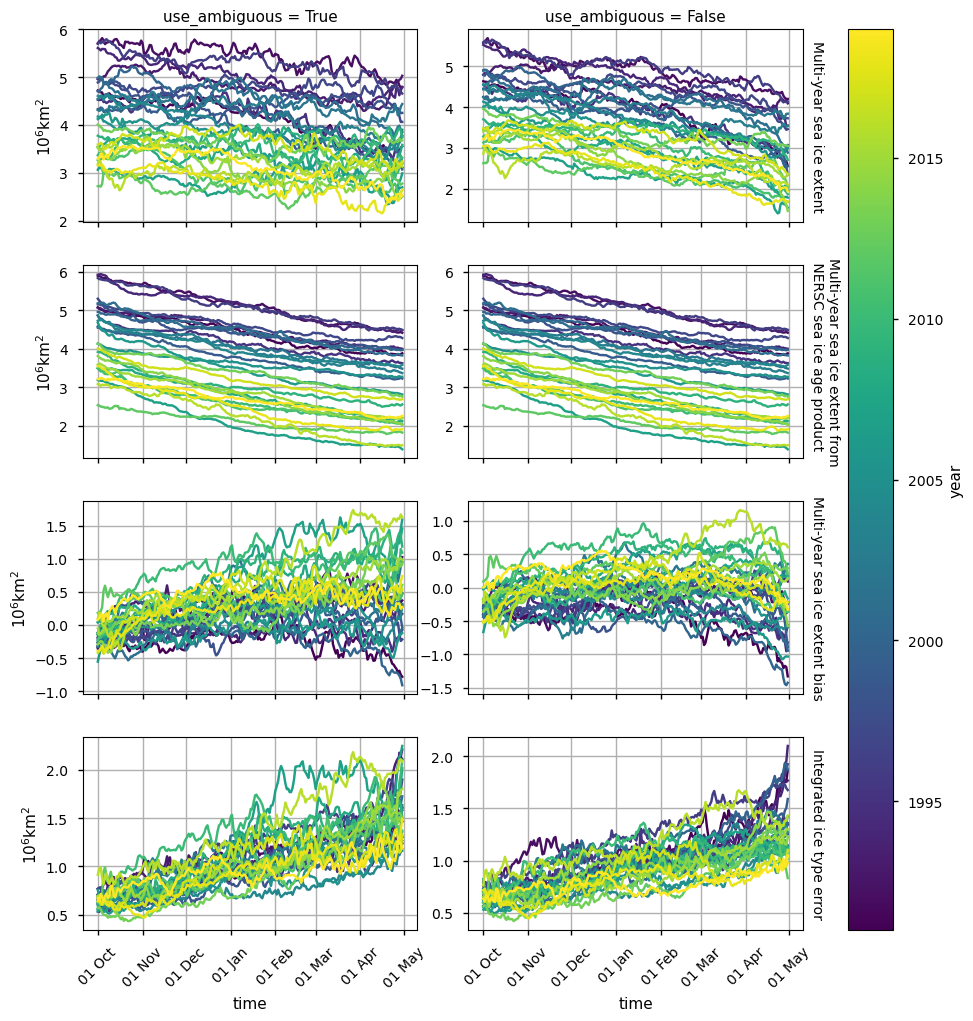

In [18]:
facet = plot_against_monthday(ds_timeseries, col="use_ambiguous", sharey=False, figsize=(10, 10))
plt.show()